In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from datetime import datetime
import tensorflow
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
from pmdarima import auto_arima
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)

In [25]:
!pip install xlrd

### Introduction

As stock market prices exhibit random walk (Fama, 1995), it is considered the most
challenging task to predict the magnitude and directional changes of stock prices as it has always
been a knotty problem (Meher et al., 2021). Therefore, investors always demand accurate stock
market forecasting as correct prediction about share prices ultimately facilitates them to make an
informed decision in their future investment plans.

ARIMA is currently wildely used to predict these trends. Mid to long term horizons could be predicted from past historical data. With the arrival of machne learning, even short term horizons could be predicted by adding a neural network to the ARIMA method. Among RF, SVM and ANN, ANN seemed to have delivered the best results which is why we will choose it for this study. 

This study aims to forecast Nestlé's stock price by using its daily closing price serie. To begin, we will assess weither or not the stock price can be predicted from conventional time serie models. Then, we will build our hybrid machine learning model and find the best model (with the lowest error rate and highest accuracy). Linear and non linear models will be considered. Our hope is to reach enough predictive confidence for investors to rely on our model to make successfull investments.

### Preparing the dataset for the time serie analysis

In [26]:
tickerSymbol = 'AAPL'
data= pd.read_csv('AAPL.csv')
data_daily= pd.read_csv('AAPL_daily.csv')
data_weekly= pd.read_csv('AAPL_weekly.csv')
data_monthly= pd.read_csv('AAPL_monthly.csv')
df = pd.DataFrame(data)
df_day = pd.DataFrame(data_daily)
df_week = pd.DataFrame(data_weekly)
df_mon = pd.DataFrame(data_monthly)
dfs = [df_day, df_week, df_mon]
for df in dfs:
    print(df.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [27]:
for df in dfs:
    print(df.isna().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [28]:
for i, df in enumerate(dfs):
    print(dfs[i])
    dfs[i] = dfs[i].rename(columns={"Date": "date", "Close": "close", 'Open':'open', 'High':'highest', 'Low':'lowest','Volume':'volume'})
    dfs[i]['returns'] = ((dfs[i]['close'] - dfs[i]['open']) / dfs[i]['open']) * 100
    dfs[i]['date_'] = dfs[i]['date']
    dfs[i].set_index("date_", inplace=True)

            Date       Open       High        Low      Close  Adj Close  \
0     2008-02-01   4.865714   4.878214   4.720714   4.776786   4.071817   
1     2008-02-04   4.793214   4.853571   4.693571   4.701786   4.007886   
2     2008-02-05   4.658214   4.785714   4.603571   4.620000   3.938171   
3     2008-02-06   4.672500   4.711429   4.348929   4.357143   3.714106   
4     2008-02-07   4.284643   4.456429   4.188214   4.330000   3.690970   
...          ...        ...        ...        ...        ...        ...   
3066  2020-04-07  67.699997  67.925003  64.750000  64.857498  63.690235   
3067  2020-04-08  65.684998  66.842499  65.307503  66.517502  65.320358   
3068  2020-04-09  67.175003  67.517502  66.175003  66.997498  65.791725   
3069  2020-04-13  67.077499  68.425003  66.457497  68.312500  67.083061   
3070  2020-04-14  70.000000  72.062500  69.512497  71.762497  70.470955   

          Volume  
0     1010744000  
1      899234000  
2     1141042000  
3     1573272400  
4   

In [29]:
for df in dfs:
    print(df.describe())

              open      highest       lowest        close    Adj Close  \
count  3071.000000  3071.000000  3071.000000  3071.000000  3071.000000   
mean     25.073663    25.319095    24.831513    25.085161    23.213939   
std      16.788261    16.971821    16.640988    16.820934    16.666973   
min       2.835357     2.928571     2.792857     2.792857     2.380681   
25%      11.955714    12.028393    11.849822    11.947143    10.183958   
50%      22.321428    22.547501    22.096430    22.296785    19.256674   
75%      35.310000    35.452501    35.076251    35.246251    33.128231   
max      81.184998    81.962502    80.837502    81.800003    80.327812   

             volume      returns  
count  3.071000e+03  3071.000000  
mean   3.782496e+08     0.021805  
std    3.285542e+08     1.587396  
min    4.544800e+07   -12.004678  
25%    1.351788e+08    -0.764913  
50%    2.767912e+08     0.053264  
75%    5.017710e+08     0.839450  
max    2.622057e+09    12.952174  
             open 

### Checking the stationary of the data: stock value

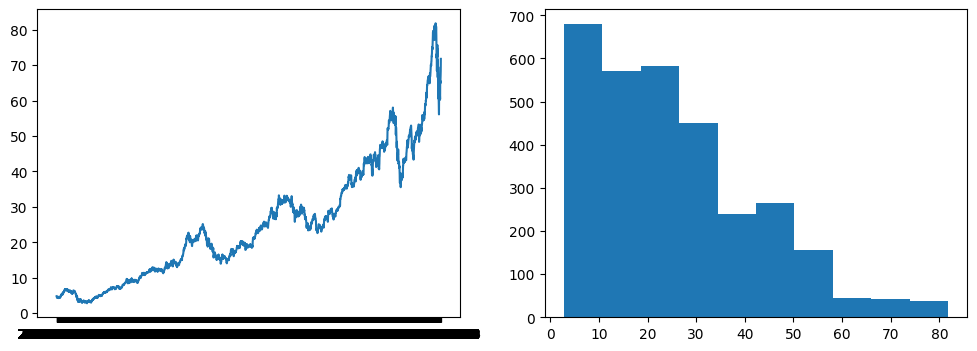

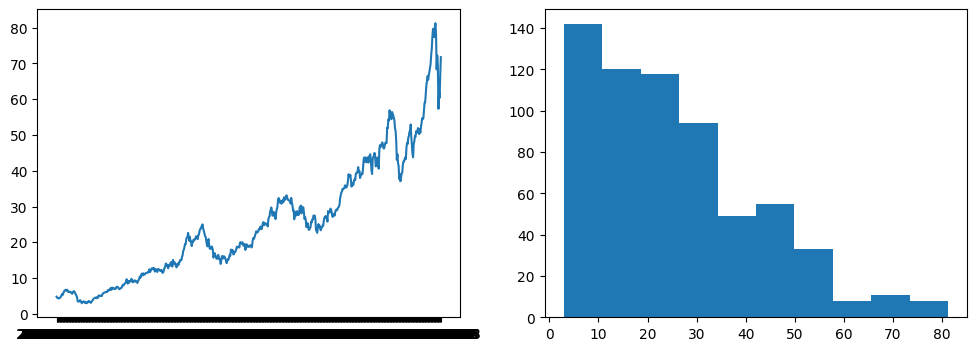

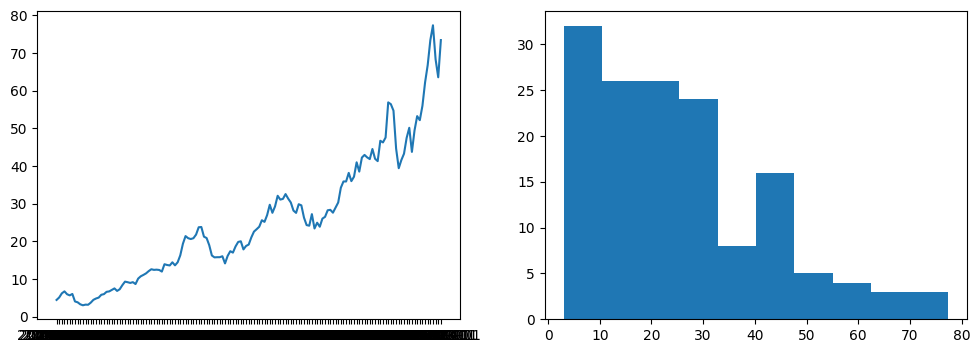

In [30]:
for i, df in enumerate(dfs):
    y =  dfs[i]['close']
    f = plt.figure(figsize=(12,4))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(y)
    ax2.hist(y)


In [31]:
#spliting the data into 5 chunks
y = dfs[0]['close'][:3000]
chunks = np.split(dfs[0]['close'][:3000], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 4.65089287  6.81743214 11.42382739 18.77895837 17.29391308 24.55688331
 28.22148333 31.34281658 45.4204418  51.13039999]
[ 1.61354091  2.20370937  1.99643786 14.06341094  3.15312112 17.14661286
  8.5963908  23.53547735 27.31237868 71.78572087]


#### Observation:

There appears to be a trend in the data. The p-value will confirm if weather or not the data is stationary.

In [32]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [33]:
print(pvalue)

0.9971534577050603


#### Conclusion:

We fail to reject the null hypothesis, meaning the dataset is non-stationary if we work with closing prices. However, there is another approach which consists in computing the returns which are supposed to be normally distributed around 0.

#### Analyzing the correlogram

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


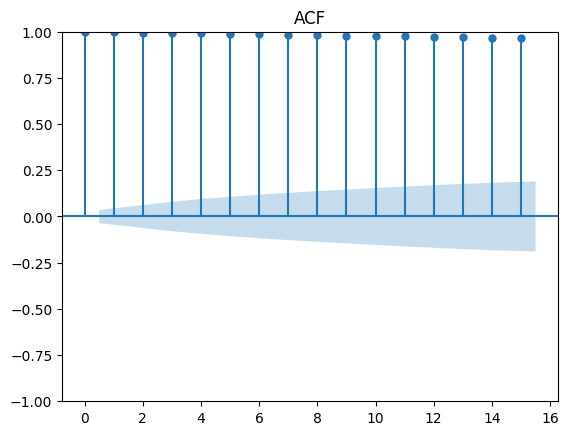

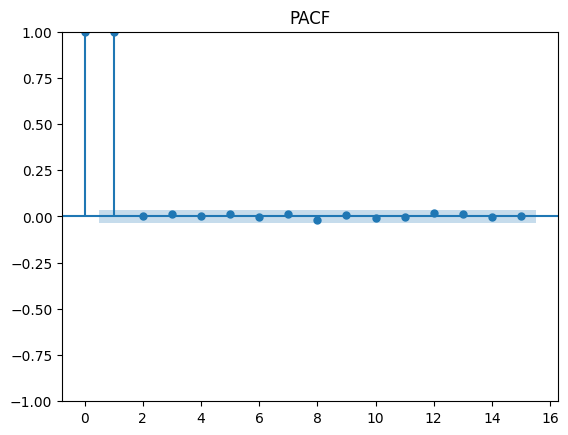

In [34]:
#Autocorrelation
acf_plot = plot_acf(y, lags=15, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y, lags=15, title='PACF')

#### Observation:

The autocorrelations are positive for many number of lags (10), so the series needs further differencing. The stock return (difference between opening and closing stock price) might provide the mean to reach stationarity.

### Building a forecasting ARIMA model

The ARMA models combines the AR models and the MA models. The ARMA(p,q) contains the AR(p) and the MA(q) and can be used for univariate time series.

The main assumption in time series analysis is that the time series is stationary and this is not the case for many pratical situations. The solution to this can be found in the Autoregressive Integrated Moving Average(ARIMA) model. The ARIMA (p,d,q) introduces the possibility to apply differencing to the data d times in order to make it stationary. After the differenciation, the model becomes ARMA(p,q).

ARIMA is a natural extension to the class of ARMA models — they can reduce a non-stationary series to a stationary series using a sequence of differences.

ARIMA model has 3 parameters:

P — Auto regressive feature of the model (number of lags of Y to be used as predictors)

D — Differencing order (minimum number of differencing needed to make the series stationary)

Q — Moving average feature of the model (number of lagged forecast errors that should go into the ARIMA Model)


#### Finding the order of differencing (d)

The purpose of differencing it to make the time series stationary. Let's start with a first order of differencing.

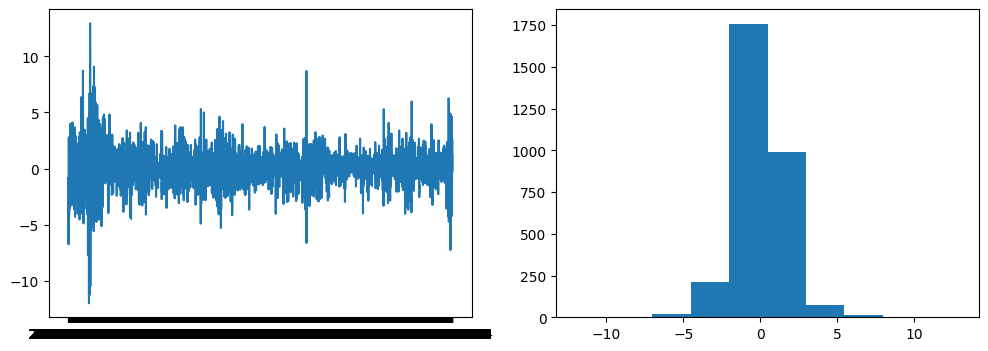

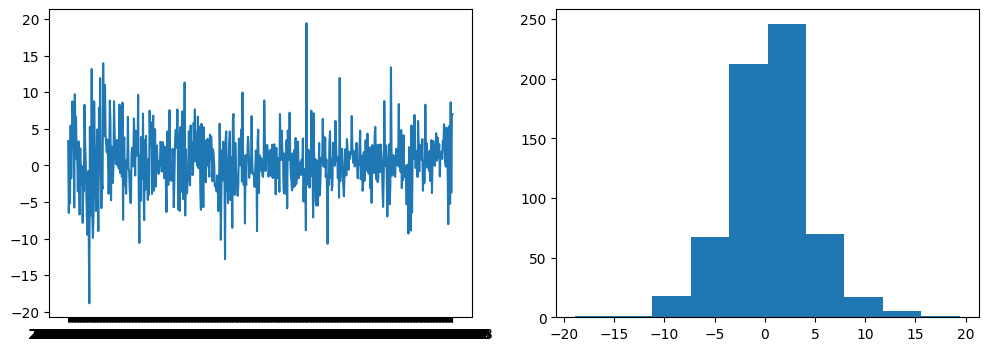

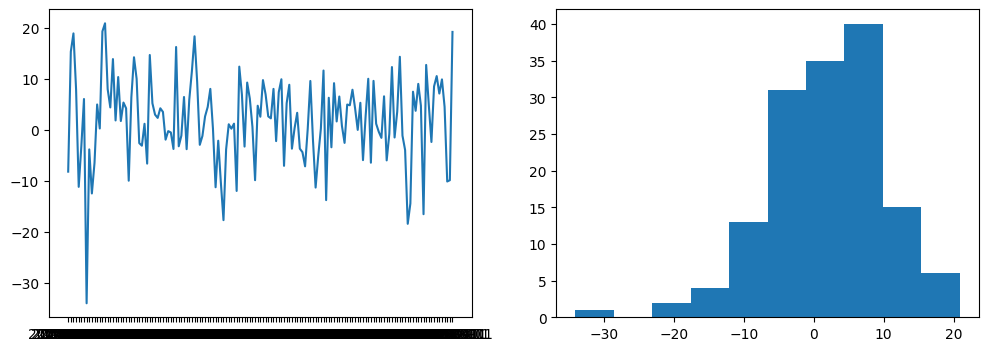

In [35]:
for i, df in enumerate(dfs):
    y =  dfs[i]['returns']
    f = plt.figure(figsize=(12,4))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(y)
    ax2.hist(y)


#### Observation:

the data seems to be distributed around a mean of 0 which could mean it is stationary. The p-value will confirm it:

In [36]:
#spliting the data into 5 chunks
y = dfs[0]['returns'][:3000]
chunks = np.split(dfs[0]['close'][:3000], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 4.65089287  6.81743214 11.42382739 18.77895837 17.29391308 24.55688331
 28.22148333 31.34281658 45.4204418  51.13039999]
[ 1.61354091  2.20370937  1.99643786 14.06341094  3.15312112 17.14661286
  8.5963908  23.53547735 27.31237868 71.78572087]


In [37]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [38]:
print(pvalue)

1.0684229735313124e-29


#### Conclusion:

P_value < 0.05, so we reject the null hypothesis, meaning the dataset is stationary if we work with stock returns.

### Analyzing the correlogram

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


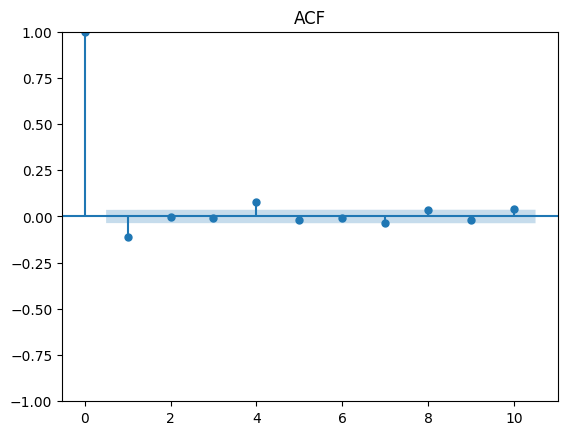

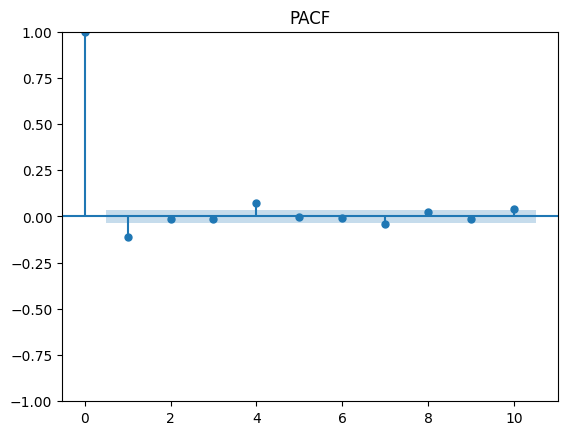

In [39]:
#Autocorrelation
acf_plot = plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y, lags=10, title='PACF')

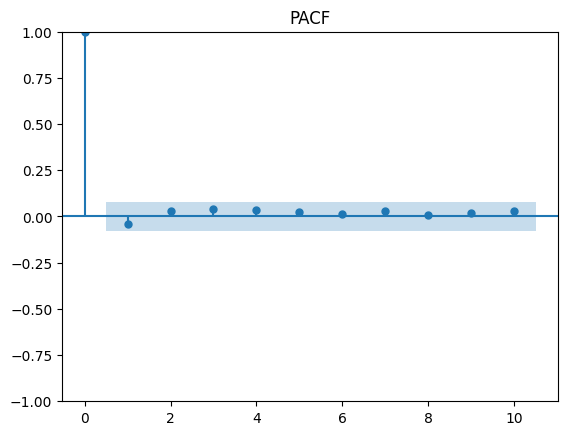

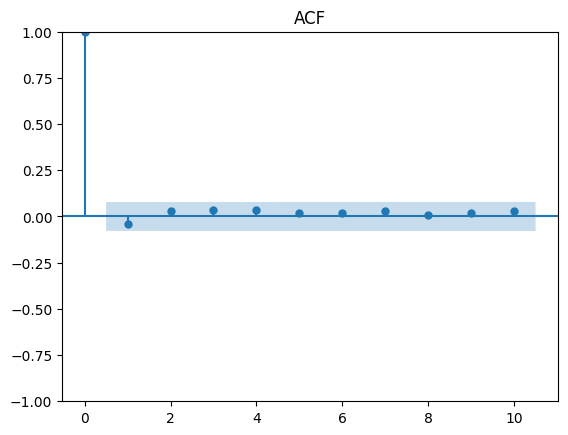

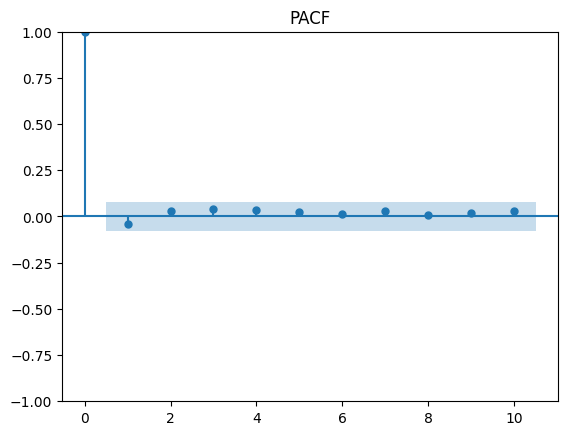

In [40]:
y = dfs[1]['returns'][:630]
#Autocorrelation
plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
plot_pacf(y, lags=10, title='PACF')

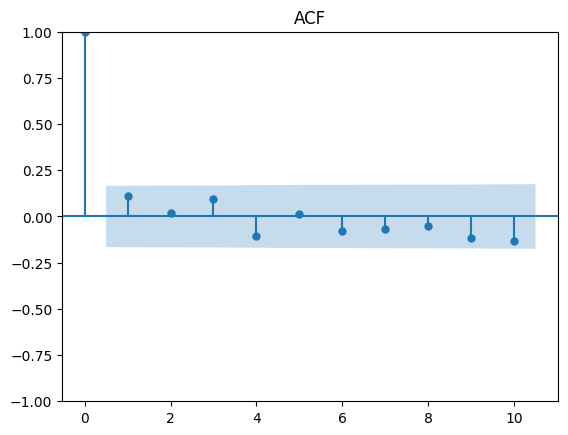

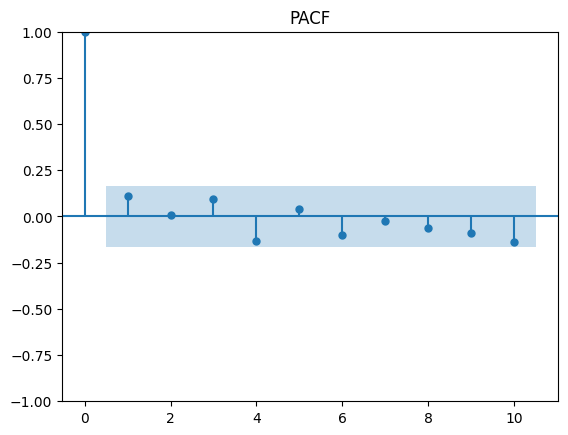

In [41]:
y = dfs[2]['returns'][:140]
#Autocorrelation
plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
acf_plot = plot_pacf(y, lags=10, title='PACF')

#### Observation:

Firstly, we notice than smoothing the signal by taking a weekly or monthly timescale does not help in improving the correlograms. Then we notice that the ACF and the PACF cut off at lag 1. We also notice that on lag 4, we have a strong signal on the PACF (representing the AR part of an ARMA model) which could be due to the fact that the stock market is open 5 days a week. The first order differencing seems to have made the data stationary.

#### Finding the AR term (p)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. The PACF plot has a significant spike at lag 1 and 4, meaning that all the higher-order autocorrelations are effectively explained by these lags. We will be conservative and take a p = 1 to start with and then compute again with a p = 4.

#### Finding the MA term (q)

To find this parameter, we can simply take a look at the ACF for the number of MA terms. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series. The ACF cuts off at lag 1 and 4, so we will take q = 1 and then q = 4.

#### Building the ARIMA models

In [42]:
# Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    print('Model parameters = %s' % (list(model_fit.params)))
    print(model_fit.summary())
    return prediction

#### ARIMA (1,1,1)

In [43]:
y = dfs[0]['close'][:3000]
nb_elements = len(y)
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 1,1,1)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)

Model parameters = [0.18611087060924003, -0.18255385860530718, 0.09108627085854892]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -463.834
Date:                Tue, 20 Dec 2022   AIC                            933.668
Time:                        00:07:00   BIC                            950.615
Sample:                             0   HQIC                           939.875
                               - 2100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1861      4.467      0.042      0.967      -8.570       8.942
ma.L1         -0.1826      4.470     -0.041    

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.27963085646843383, 0.3004095935367178, 0.09207067294716384]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2235
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -505.662
Date:                Tue, 20 Dec 2022   AIC                           1017.324
Time:                        00:07:44   BIC                           1034.458
Sample:                             0   HQIC                          1023.580
                               - 2235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2796      0.668     -0.418      0.676      -1.589       1.030
ma.L1          0.3004      0.665      0.452     

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.26829739015028903, 0.2881385757086635, 0.09215233124504721]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -519.592
Date:                Tue, 20 Dec 2022   AIC                           1045.184
Time:                        00:08:12   BIC                           1062.394
Sample:                             0   HQIC                          1051.460
                               - 2292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2683      0.706     -0.380      0.704      -1.652       1.116
ma.L1          0.2881      0.703      0.410     

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.2694922181752923, 0.2893104879352453, 0.0921180510205771]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2293
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -519.391
Date:                Tue, 20 Dec 2022   AIC                           1044.782
Time:                        00:08:12   BIC                           1061.994
Sample:                             0   HQIC                          1051.059
                               - 2293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2695      0.706     -0.382      0.703      -1.653       1.114
ma.L1          0.2893      0.703      0.412      0

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.25127651288198266, 0.2689838674561997, 0.09446188339407709]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2369
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -566.334
Date:                Tue, 20 Dec 2022   AIC                           1138.668
Time:                        00:08:46   BIC                           1155.977
Sample:                             0   HQIC                          1144.969
                               - 2369                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2513      0.814     -0.309      0.758      -1.847       1.345
ma.L1          0.2690      0.812      0.331     

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model parameters = [-0.10883991873260121, 0.15432136279043732, 0.12362211464844007]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2683
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1002.217
Date:                Tue, 20 Dec 2022   AIC                           2010.434
Time:                        00:10:48   BIC                           2028.117
Sample:                             0   HQIC                          2016.831
                               - 2683                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1088      0.289     -0.377      0.706      -0.675       0.457
ma.L1          0.1543      0.287      0.537    

In [23]:
#Print MSE to see how good the model is
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(Test,Predictions))
print(mean_absolute_error(Test,Predictions))
Error = mean_absolute_percentage_error(Test, Predictions)
print('Test Mean Absolute percentage error: %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.figure(figsize=(35,20))
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [900, 25]

#### ARIMA (4,1,4)

In [22]:
y = dfs[0]['close'][:3000]
nb_elements = len(y)
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 4,1,4)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

Model parameters = [0.2921485964486355, 0.34672950590646157, 0.5483242826682337, -0.6794609787738461, -0.28038855705723986, -0.3659719243296192, -0.5705448746865894, 0.69866993693734, 0.09071005298477335]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2100
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.958
Date:                Mon, 19 Dec 2022   AIC                            935.916
Time:                        23:42:58   BIC                            986.759
Sample:                             0   HQIC                           954.539
                               - 2100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3089280768086885, 0.3673386405699, 0.5836855814630337, -0.6616585877113731, -0.29688324791147863, -0.390318136113325, -0.6029436814490616, 0.6810720972529217, 0.09086921542891371]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2101
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.728
Date:                Mon, 19 Dec 2022   AIC                            935.457
Time:                        23:43:01   BIC                            986.304
Sample:                             0   HQIC                           954.081
                               - 2101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1   

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3751102435392086, 0.42746295132558765, 0.6511933349270791, -0.6964089629666403, -0.37273065495729957, -0.45124979848922686, -0.6643854463989335, 0.7207259421821456, 0.09073566400637252]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2102
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.480
Date:                Mon, 19 Dec 2022   AIC                            934.961
Time:                        23:43:05   BIC                            985.812
Sample:                             0   HQIC                           953.586
                               - 2102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3001921709701034, 0.3609728518786015, 0.5592196209748509, -0.6725326163995573, -0.28690439520866945, -0.38062066484238727, -0.5827293718499923, 0.6926335361746251, 0.09051782755611493]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2103
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.242
Date:                Mon, 19 Dec 2022   AIC                            934.484
Time:                        23:43:08   BIC                            985.339
Sample:                             0   HQIC                           953.110
                               - 2103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2995766050196539, 0.3596194903236566, 0.5563739665121992, -0.681591720470279, -0.2894234023529046, -0.37836817784320004, -0.5784973011496214, 0.7020775781013385, 0.09081239859841574]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2104
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.065
Date:                Mon, 19 Dec 2022   AIC                            934.130
Time:                        23:43:11   BIC                            984.990
Sample:                             0   HQIC                           952.758
                               - 2104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2967320097855898, 0.3547310741718631, 0.5486129116661278, -0.6838986632382215, -0.28635920105139145, -0.3746435726726711, -0.5713828724074366, 0.7054567641659255, 0.09049377616457392]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2105
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -457.968
Date:                Mon, 19 Dec 2022   AIC                            933.936
Time:                        23:43:14   BIC                            984.800
Sample:                             0   HQIC                           952.564
                               - 2105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.30262523124795404, 0.3886435510670264, 0.5659104120641834, -0.6773088973593944, -0.29213452821896646, -0.4061955603834016, -0.5907387609003922, 0.6973945343312189, 0.09069880692273231]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2106
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.401
Date:                Mon, 19 Dec 2022   AIC                            934.802
Time:                        23:43:17   BIC                            985.671
Sample:                             0   HQIC                           953.432
                               - 2106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.29231508903735925, 0.34961313336342065, 0.548477394200674, -0.6780403833401613, -0.281822952579345, -0.3696556969026554, -0.5706853092286126, 0.6989193028095012, 0.09050318254916945]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2107
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.135
Date:                Mon, 19 Dec 2022   AIC                            934.271
Time:                        23:43:20   BIC                            985.144
Sample:                             0   HQIC                           952.901
                               - 2107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.29412934208163705, 0.34815303890896976, 0.5489991879949436, -0.679186424726564, -0.2836918607524412, -0.368075149739593, -0.5710014428754888, 0.7007753993453792, 0.09044286105118464]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2108
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -457.870
Date:                Mon, 19 Dec 2022   AIC                            933.740
Time:                        23:43:23   BIC                            984.617
Sample:                             0   HQIC                           952.372
                               - 2108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2934676137207074, 0.35369133791326934, 0.5491935578393164, -0.6767781269875499, -0.28325848295157047, -0.37350583885187705, -0.5723830481326928, 0.698951140199476, 0.09043162499670192]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2109
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -457.620
Date:                Mon, 19 Dec 2022   AIC                            933.240
Time:                        23:43:27   BIC                            984.121
Sample:                             0   HQIC                           951.873
                               - 2109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.32210420419052954, 0.43469123066771825, 0.5751412134061511, -0.7096254687785858, -0.3168375659904803, -0.4481802485331266, -0.5978178461447887, 0.7301930638778004, 0.09038104470673575]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -459.061
Date:                Mon, 19 Dec 2022   AIC                            936.122
Time:                        23:43:30   BIC                            987.007
Sample:                             0   HQIC                           954.756
                               - 2110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3390409268489257, 0.46235320929826434, 0.6220067143587064, -0.6872510856881338, -0.33874518011166993, -0.4787635456620454, -0.6405954332204438, 0.7131471387456978, 0.09052675985339007]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2111
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.759
Date:                Mon, 19 Dec 2022   AIC                            935.517
Time:                        23:43:33   BIC                            986.407
Sample:                             0   HQIC                           954.152
                               - 2111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2896371815905291, 0.37197744903523833, 0.5538892734771942, -0.6795644154593169, -0.28191579761777175, -0.3907258335799171, -0.5773222926131478, 0.7024098447027864, 0.09043601688893743]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2112
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.686
Date:                Mon, 19 Dec 2022   AIC                            935.372
Time:                        23:43:36   BIC                            986.266
Sample:                             0   HQIC                           954.008
                               - 2112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2843297665952441, 0.3521858125117767, 0.5472382583078346, -0.6756490929655874, -0.2744789266188129, -0.3718023462154677, -0.5697530744693816, 0.697359558539652, 0.09038732091604222]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2113
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.462
Date:                Mon, 19 Dec 2022   AIC                            934.923
Time:                        23:43:39   BIC                            985.822
Sample:                             0   HQIC                           953.561
                               - 2113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.2995516898830357, 0.3900714315936288, 0.5525116178941506, -0.6973759787658257, -0.29104743826559626, -0.4067122488275662, -0.5761759189804403, 0.7185137357683788, 0.09029009182361508]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2114
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -458.314
Date:                Mon, 19 Dec 2022   AIC                            934.627
Time:                        23:43:42   BIC                            985.530
Sample:                             0   HQIC                           953.266
                               - 2114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.39357792906009886, 0.4837206225279382, 0.587142474158179, -0.7946965311563525, -0.38784202941488644, -0.4951642432037898, -0.6034915109200589, 0.8095505381628139, 0.09072683901721211]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2115
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -460.523
Date:                Mon, 19 Dec 2022   AIC                            939.045
Time:                        23:43:46   BIC                            989.952
Sample:                             0   HQIC                           957.685
                               - 2115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.35223494153730245, 0.44310960108819786, 0.5588199394352655, -0.7627964694550293, -0.3470621809537801, -0.45526748754683477, -0.57965962449695, 0.7803805873544015, 0.09060127759985408]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2116
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -460.967
Date:                Mon, 19 Dec 2022   AIC                            939.933
Time:                        23:43:49   BIC                            990.844
Sample:                             0   HQIC                           958.574
                               - 2116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.4117338753338423, 0.4964658637157775, 0.5906925006678285, -0.8099528933932348, -0.4054378310519829, -0.5068580786079511, -0.6085923949434309, 0.8237814488829185, 0.09045144763704452]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2117
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -461.221
Date:                Mon, 19 Dec 2022   AIC                            940.442
Time:                        23:43:53   BIC                            991.357
Sample:                             0   HQIC                           959.084
                               - 2117                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.4305901556786259, 0.5185727338655097, 0.5943039591971284, -0.8254685730100781, -0.42608218729686775, -0.5250766394179404, -0.61173919947278, 0.8424492620930796, 0.0906133028199484]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2118
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -461.021
Date:                Mon, 19 Dec 2022   AIC                            940.041
Time:                        23:43:56   BIC                            990.961
Sample:                             0   HQIC                           958.684
                               - 2118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1  

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3469999898260179, 0.4281278425558586, 0.5479340810373204, -0.7562557578421836, -0.3396592107663804, -0.4425498616613395, -0.5714275488770567, 0.7730733160145794, 0.09078853725716943]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2119
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -461.779
Date:                Mon, 19 Dec 2022   AIC                            941.559
Time:                        23:44:00   BIC                            992.483
Sample:                             0   HQIC                           960.203
                               - 2119                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.35381888055066935, 0.4381067005868253, 0.5565641816206606, -0.7598205942045921, -0.34378296840261413, -0.4508924499535849, -0.5780969218372578, 0.7760271713155276, 0.09055557149390774]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2120
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -461.479
Date:                Mon, 19 Dec 2022   AIC                            940.957
Time:                        23:44:04   BIC                            991.885
Sample:                             0   HQIC                           959.602
                               - 2120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.3906141579669885, 0.4685022062688242, 0.5649247720370246, -0.7979615063649831, -0.3878385761745944, -0.48206517063724247, -0.5830947084086819, 0.81650178025006, 0.09034845968410732]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2121
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -461.378
Date:                Mon, 19 Dec 2022   AIC                            940.756
Time:                        23:44:07   BIC                            991.689
Sample:                             0   HQIC                           959.402
                               - 2121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.43997498567873, 0.5091369189052872, 0.5868803883920711, -0.8353746190290597, -0.43523206222943284, -0.5206435919183505, -0.6044172265120691, 0.8521919948715605, 0.09067502894697844]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2122
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -460.875
Date:                Mon, 19 Dec 2022   AIC                            939.750
Time:                        23:44:11   BIC                            990.687
Sample:                             0   HQIC                           958.397
                               - 2122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.4618874726038373, 0.5229241760051302, 0.5963774102206856, -0.852613586127574, -0.4624133717711129, -0.5349429841971387, -0.6102913229518494, 0.8738620323180675, 0.09058971526805475]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2123
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -460.598
Date:                Mon, 19 Dec 2022   AIC                            939.195
Time:                        23:44:14   BIC                            990.136
Sample:                             0   HQIC                           957.844
                               - 2123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Antony\Documents\HES-SO\Code\HES\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model parameters = [0.44332594280586923, 0.5119571756646885, 0.5839772203694469, -0.8428556160402663, -0.4445010857537752, -0.5228387646181314, -0.5984008149319802, 0.8651780179891916, 0.09008914286771097]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2124
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -460.590
Date:                Mon, 19 Dec 2022   AIC                            939.180
Time:                        23:44:18   BIC                            990.126
Sample:                             0   HQIC                           957.830
                               - 2124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

KeyboardInterrupt: 

0.45218254952432996
0.45473619463378917
Test Mean Absolute percentage error : 0.010


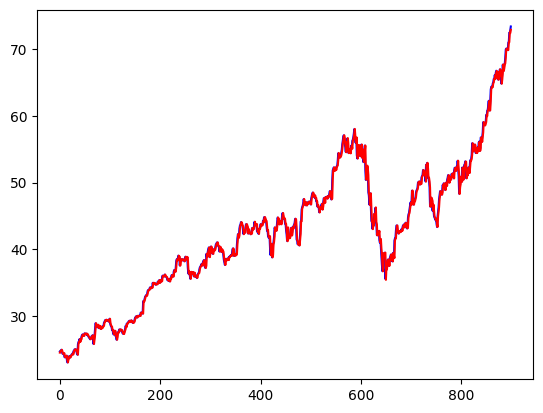

In [46]:
#Print MSE to see how good the model is
Error = mean_absolute_percentage_error(Test, Predictions)
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(Test,Predictions))
print(mean_absolute_error(Test,Predictions))
print('Test Mean Absolute percentage error : %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### Observation:

The ARIMA (1,1,1) found previously seems to produce good predictive results with no lag in the signal. All coefficients are over the significance threshold and the MSE is very low. As for the ARIMA(4,1,4), the results are quite similar but the computing cost is much higher.

#### Conclusion:

So, we seem to have a decent ARIMA model. But is that the best? We need to dig further to draw relevant conclusions that is to predict the future. In the next section, a bot will be trained to take decisions based on the ARIMA's (1,1,1) predicted return values, to buy or sell stock shares with hope to make a profit ! we will also try a simpler model AR(1).

#### Auto ARIMA forecast Python function

In [ ]:
y = dfs[0]['close'][:3000]

model = auto_arima(y, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3665.185, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3663.899, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3665.509, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3665.467, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3669.806, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.042 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3000
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1829.949
Date:                Wed, 14 Dec 2022   AIC                           3663.899
Time:                        18:57:55   BIC                           3675.911
Sample:                             0   HQIC                          3668.220
                               - 3000                                       

#### Observation:

The AIC scores are very close from one model to another though the function did not exceed an order of 1.

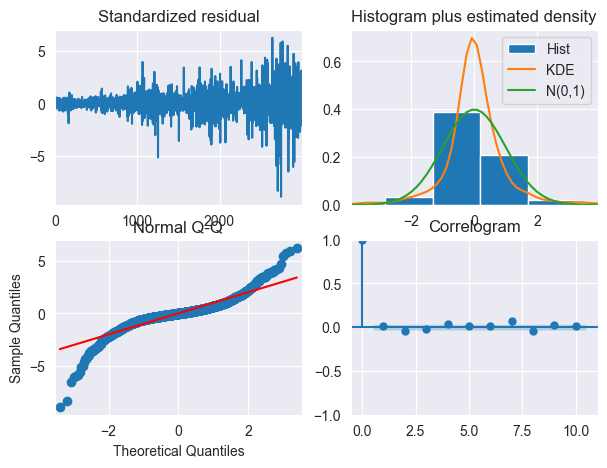

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#### Observation:

The correlogram of residuals is flat which is ideal meaning that the residual erros are not autocorrelated (residuals in a time serie is what is left over after fitting a model). The density plot suggest normal distribution with mean zero. Overall, this model seems like a good fit. Let's move on to the next step, setting up the stock bot and comparing its financial performance based on different ARIMA / AR models.



#### Setting up the bot

In [ ]:
def run_simulation(returns, prices, amt, order, n, m, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
    curr_holding = False
    events_list = []
    predictions = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[3000:].items(), total=len(returns.iloc[3000:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = prices[:date].to_numpy()
        curr_data = [x for x in curr_data]
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=(n,1,m))
                model_fit = model.fit()
                #get forecast
                pred = model_fit.forecast()
                yhat = pred[0]
                predictions.append(yhat)
            except:
                pred = thresh - 1
                predictions.append(pred)
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
                ((type(order) == float and np.random.random() < order)
                 or (type(order) == tuple and pred > thresh)
                 or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[3000:])
        plt.xticks(np.arange(0, len(prices[3000:]), step=10), rotation=30)

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(3000*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt


#### Model 1: Random buying

The model will be computed several times and the average financial performance will be assessed.

In [ ]:
final_avg_perf = [run_simulation(dfs[0]['returns'], dfs[0]['close'], 100, 0.5, None, 0, 0, verbose=False, plot=False) for _ in range(0,200)]

100%|██████████| 71/71 [00:00<00:00, 13523.87it/s]


Text(0.5, 1.0, 'Avg: $97.33\nSD: $19.67')

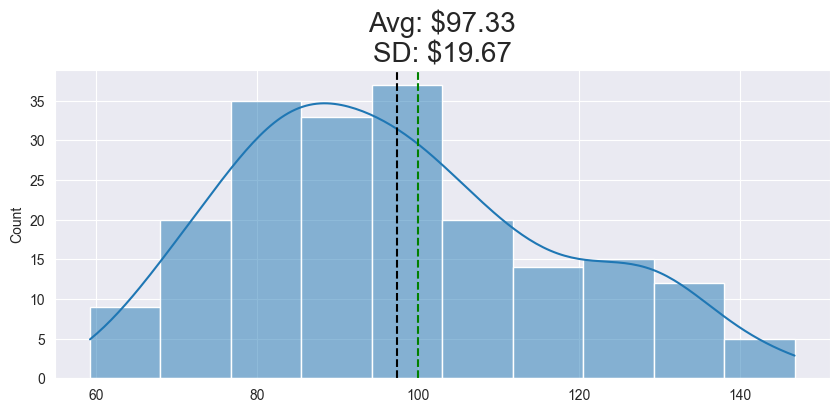

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(final_avg_perf,kde=True)
plt.axvline(np.mean(final_avg_perf), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_avg_perf),2), round(np.std(final_avg_perf),2)), fontsize=20)

#### Observation:

The bot didn't do well with a random buying model. In fact, we lost money of our initial investment of 100 dollars. In addition, the high variability (SD of 20) represents too much risk from a business perspective.

Model 2: ARIMA(1,1,1)

100%|██████████| 71/71 [00:06<00:00, 11.70it/s]


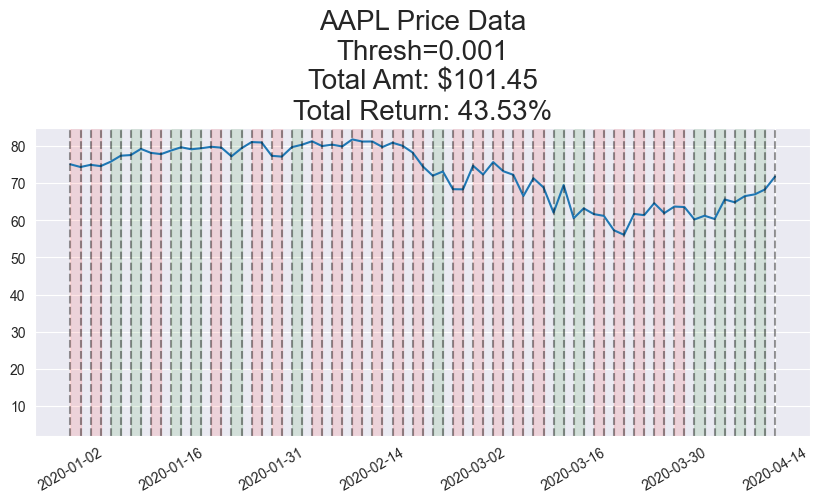

101.45097609862214

In [ ]:
run_simulation(dfs[0]['returns'], dfs[0]['close'], 100, (1,1,1), 1, 1, 0.001, verbose=False, plot=True)

#### Observation:

Success ! We managed to make a profit of our initial investment. The model seems to produce good results. However, this is cruelly misleading as any unexpected variations in the signal (such as covid) would severally impede the model's performance.

#### Further Improvements

Forecasting Apple's stock value can be improved by:

- Constantly updating model parameters (costly to compute)
- Inputting additional economical factors that impact stock values and their correlations into account (harder to compute)
- Model parameters can also be updated via machine learning and optimisation techniques (next step of this study)

Financial markets can move in any direction and this makes it very hard, if not impossible, to accurately predict exchange rates. Having said that, the sole purpose of forecasting exchange rates via ARIMA is to help us in taking calculated decisions that maximise returns and minimise risks. Forecasted exchange rates are dependent on the assumptions imposed by ARIMA model which are based on auto regression, integrated and moving average concepts.

ARIMA is a simple yet powerful model. It assumes that the historic values dictate behaviour of present. It also assumes that the data does not contain anomalies, is stationary and model parameters along with error term is constant.

Although ARIMA does not take stresses in market data as input (which are complexe and difficult to conceptualize) such as economical downturns and disruptives political changes, or correlations of all risk factors to forecast stock markets but the simple example demonstrated above can be useful for forecasting stable stocks in normal conditions in which past behaviour dictates present and future values.